In [1]:
!pip install kaggle


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"makkmak12","key":"c2e0b01024d5688fae2e5f4e2dcd1210"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d darshan1504/covid19-detection-xray-dataset



Dataset URL: https://www.kaggle.com/datasets/darshan1504/covid19-detection-xray-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 63% 118M/186M [00:00<00:00, 1.24GB/s]
100% 186M/186M [00:00<00:00, 950MB/s] 


In [8]:
# Step 5: Unzip the dataset
import zipfile

with zipfile.ZipFile("covid19-detection-xray-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("covid_xray_dataset")


In [9]:
!ls covid19-detection-xray-dataset.zip-dataset-images

ls: cannot access 'covid19-detection-xray-dataset.zip-dataset-images': No such file or directory


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
IMG_SIZE=224
BATCH_SIZE=32

In [12]:
train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [13]:
train_generator=train_datagen.flow_from_directory(
    '/content/covid_xray_dataset/TrainData',
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 1667 images belonging to 5 classes.


In [14]:
val_generator=train_datagen.flow_from_directory(
    '/content/covid_xray_dataset/TrainData',
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Changed from 'categorical' to 'sparse'
    subset='validation'
)


Found 416 images belonging to 5 classes.


In [15]:
class_indices=train_generator.class_indices
class_names=list(class_indices.keys())
print(class_indices)

{'BacterialPneumonia': 0, 'COVID-19': 1, 'Normal': 2, 'OversampledAugmentedCOVID-19': 3, 'ViralPneumonia': 4}


In [21]:
model=keras.Sequential([
    layers.Conv2D(32,(3,3),activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(5,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
model.fit(train_generator,epochs=10,validation_data=val_generator,batch_size=BATCH_SIZE)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4287 - loss: 1.9822

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.4303 - loss: 1.9715 - val_accuracy: 0.6274 - val_loss: 0.9632
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6472 - loss: 0.9196 - val_accuracy: 0.7115 - val_loss: 0.8171
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6858 - loss: 0.8140 - val_accuracy: 0.6875 - val_loss: 0.7735
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.7782 - loss: 0.5857 - val_accuracy: 0.6731 - val_loss: 0.8381
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8295 - loss: 0.4613 - val_accuracy: 0.6755 - val_loss: 0.9800
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8881 - loss: 0.2937 - val_accuracy: 0.7019 - val_loss: 1.1231
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9368 - loss: 0.1790 - val_accuracy: 0.6875 - val_loss: 1.3692
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9710 - loss: 0.0855 - val_accuracy: 0.7067 - val_loss: 

In [25]:
model.save('/content/covid_xray_dataset/TrainData_model.h5')

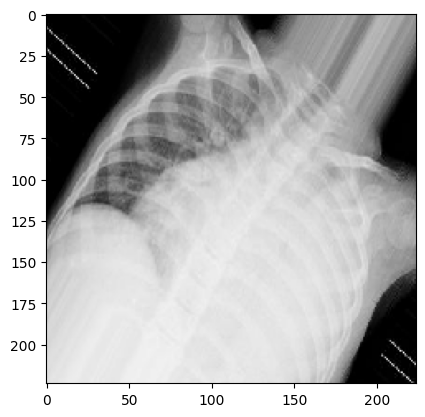

In [29]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

test_image_path="/content/covid_xray_dataset/TrainData/BacterialPneumonia/_105_2462475.jpeg"
img=image.load_img(test_image_path,target_size=(224,224))
plt.imshow(img)
plt.axis()
plt.show()

In [30]:
img_array=image.img_to_array(img)
img_array=np.expand_dims(img_array,axis=0)
img_array/=255

In [31]:
prediction=model.predict(img_array)
print(prediction)
ind=np.argmax(prediction)
print(class_names[ind])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[9.9999869e-01 3.8841603e-20 6.4284700e-13 1.2228895e-22 1.2857869e-06]]
BacterialPneumonia
